# Пошаговое руководство по созданию жидкой нейронной сети CfC с нуля
Павел Наказненко, 2024 г.

[Closed-form Continuous-Time Neural Networks](https://www.nature.com/articles/s42256-022-00556-7#Sec1)

Смотрите также: 
[Liquid Time-Constant Networks on Arxiv](https://arxiv.org/abs/2006.04439)

Благодарность: это руководство во многом основано на авторской [реализации CfC Cell] (https://github.com/raminmh/CfC/), спасибо авторам LNN.

[Телеграм-канал: ТоШоСети](https://t.me/toshoseti)

## Отказ от ответственности
Это руководство представляет собой попытку ознакомиться с LNN и тем, как они работают. Ни в коем случае это не идеальная реализация. 
Для меня это сложная тема, поэтому вероятны баги и недоразумения. Пожалуйста, действуйте по своему усмотрению.

### Understanding the CfC Cell
В прошлый раз я описал принцип устройства Liquid Time-Constant RNN и сделал тетрадку с разбором.

У LTC есть очевидный недостаток: зависимость от ODE Solver'а, который считать дорого. Авторы решили устранить этот недостаток, проанализировали динамику и пришли к closed-form решению для определения состояния Leaky Integrate Fire нейрона в любой момент времени. Решение неточное, но тесно ограничено сверху и снизу по отношению к честному ODE Solver расчету. Динамику повторяет, и ладушки.

Итак, сама статья.

Как выглядит уравнение динамики нейрона в классической LTC:
$$\frac{{\mathrm{d}}{{{\bf{x}}}}}{{\mathrm{d}}t}=-\left[{w}_{\tau }+f({{{\bf{x}}}},{{{\bf{I}}}},\theta )\right]\odot {{{\bf{x}}}}(t)+A\odot f({{{\bf{x}}}},{{{\bf{I}}}},\theta )$$
Уравнение 1. Динамика скрытого состояния LIF нейрона

Его проанализировали, выдвинули и доказали пару теорем и получили closed-form решение:
$$x(t)\approx ({x}_{0}-A){\mathrm{e}}^{-[{w}_{\tau }+f(I(t),\theta )]t}f(-I(t),\theta )+A$$
Уравнение 2. Closed-form решение для динамики скрытого состояния LIF нейрона для одномерной последовательности входных данных

Дальше обобщают уравнение (2) для общего случая многомерных входных последовательностей:
$${{{\bf{x}}}}(t)=B\odot {\mathrm{e}}^{-[{w}_{\tau }+f({{{\bf{x}}}},{{{\bf{I}}}};\theta )]t}\odot f(-{{{\bf{x}}}},-{{{\bf{I}}}};\theta )+A$$
Уравнение 3. Обобщенная форма уравнения 2

Экспоненциальный член в уравнении (3) заставляет первую часть системы (экспоненциально быстро) стремиться к нулю и весь скрытый слой стремится к A. Эта проблема становится более очевидной, когда присутствуют рекуррентные связи, и вызывает факторы исчезновения градиента при обучении методом градиентного спуска. Чтобы уменьшить этот эффект, авторы заменяют член экспоненциального затухания на обратную сигмоидальную нелинейность σ(.). Эта нелинейность приблизительно равна 1 при t = 0 и стремится к 0 в пределе t → ∞. Однако, в отличие от экспоненциального затухания, её переход происходит гораздо более плавно, что обеспечивает лучшее состояние на поверхности потерь.

Далее, авторы рассматривают параметр смещения B как часть обучаемых параметров нейронной сети f( − x, − I; θ) и используют новый экземпляр сети вместо f (представленной в факторе экспоненциального затухания). Также заменяют A на другой экземпляр нейронной сети, h(. ), чтобы повысить гибкость модели. Для получения более общей архитектуры сети авторы допускают, что нелинейность f(−x, −I; θ), представленная в уравнении (3), имеет как общие (основные), так и независимые (g(. )) компоненты сети.

Временной сигмоидальный член может играть роль гейта, если мы дополнительно умножим h(. ) на (1 − σ(. )). Таким образом, временная сигмоидальная функция представляет собой механизм гейта, который интерполирует между двумя пределами t → −∞ и t → ∞ траектории ОДУ.

Вместо обучения всех трех экземпляров нейронных сетей f, g и h отдельно, авторы предлагают сделать так, чтобы все сети имели общие первые несколько слоев в форме основного блока, который разветвляется на эти три функции. В результате основной блок позволяет нашей модели обучаться на общих представлениях, тем самым ускоряя и стабилизируя процесс обучения. Это архитектурное решение обеспечивает два одновременных преимущества: (1) Через общий основной блок устанавливается связь между временной константой системы и её нелинейностью состояния, что использует каузальное обучение представлений (2) через отдельные слои головной сети система имеет возможность изучать временные и структурные зависимости независимо друг от друга.

Эти модификации приводят к модели нейронной сети CfC:
$${\textbf{x}}(t) = \underbrace{\sigma(-f({\textbf{x}}, {\textbf{I}};\theta_f) {{\textbf{t}}})}_{{{\rm{time}}\text{-}{\rm{continuous}}\,{\rm{gating}}}} \odot g({\textbf{x}},{\textbf{I}};\theta_g) + \underbrace{\left[ 1 -\sigma(-[f({\textbf{x}}, {\textbf{I}};\theta_f)] {{\textbf{t}}}) \right]}_{{{\rm{time}}\text{-}{\rm{continuous}}\,{\rm{gating}}}} \odot h({\textbf{x}},{\textbf{I}};\theta_h)$$
Уравнение 4. Улучшенное closed-form решение для LTC

Таким образом авторы получают модель с непрерывной глубиной, которая может настраивать свое временное поведение в зависимости от задачи, проходящей тестирование. Для временно-зависимых наборов данных (например, нерегулярно отслеживаемых временных рядов, событийных данных и разреженных данных) параметр t для каждой входящей выборки устанавливается на основе её временной метки или порядка. Для последовательных приложений, где время возникновения выборки не имеет значения, t выбирается столько раз, сколько длина батча, с равными интервалами в пределах выбранного диапазона.

Вот собственно и все. Дальше авторы статьи приводят серию исследований производительности сети на разных задачах.
Приступим к реализации.

## Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

## Реализуем класс базового closed-form решения
Для этого воспользуемся формулой (2) из статьи:
$$x(t)\approx ({x}_{0}-A){\mathrm{e}}^{-[{w}_{\tau }+f(I(t),\theta )]t}f(-I(t),\theta )+A$$

In [ ]:
class CFCSolutionCell(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=4, activation_type=nn.Tanh, num_backbone_neurons=4, num_backbone_layers=1, dropout=None):
        super(CFCSolutionCell, self).__init__()

        # Сохраняем параметры
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation_type = activation_type
        self.num_backbone_neurons = num_backbone_neurons

        # Доп. слои для backbone кроме первого обязательного
        extra_layers = [
            nn.Linear(num_backbone_neurons, num_backbone_neurons),
            self.activation_type(),
            nn.Dropout(dropout) if dropout is not None else nn.Identity()
        ] * (num_backbone_layers - 1)

        # Первый обязательный слой backbone + дополнительные, если есть
        self.backbone = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, num_backbone_neurons),
            self.activation_type(),
            *extra_layers
        )

        # Линейный слой аппроксиматор функции на основе backbone
        self.f = nn.Linear(num_backbone_neurons, hidden_dim)

        # Learnable-параметры w_tau и A (смысл параметров смотри в статье Liquid Time-constant Neural Network)
        self.w_tau = torch.nn.Parameter(data=torch.zeros(1, self.hidden_dim), requires_grad=True)
        self.A = torch.nn.Parameter(data=torch.ones(1, self.hidden_dim), requires_grad=True)

    def forward(self, inputs, hx, ts):
        batch_size = inputs.size(0)  # Размер батча
        ts = ts.view(batch_size, 1)  # Меняем представление интервалов 

        x = torch.cat([inputs, hx], 1)  # Конкатенируем входы и hidden state
        x = self.backbone(x)  # Сначала пропускаем через backbone
        
        # Затем считаем аппроксимацию функции
        f_value = self.f(x)
        
        # Подставляем все в формулу 2 из статьи
        new_hidden = (-self.A * torch.exp(-ts * (torch.abs(self.w_tau) + torch.abs(f_value))) * f_value + self.A)

        return new_hidden

## Реализация улучшенной closed-form версии в виде CFCImprovedCell Class
Реализуем улучшенную версию CFCSolutionCell как описано в статье по следующей схеме:
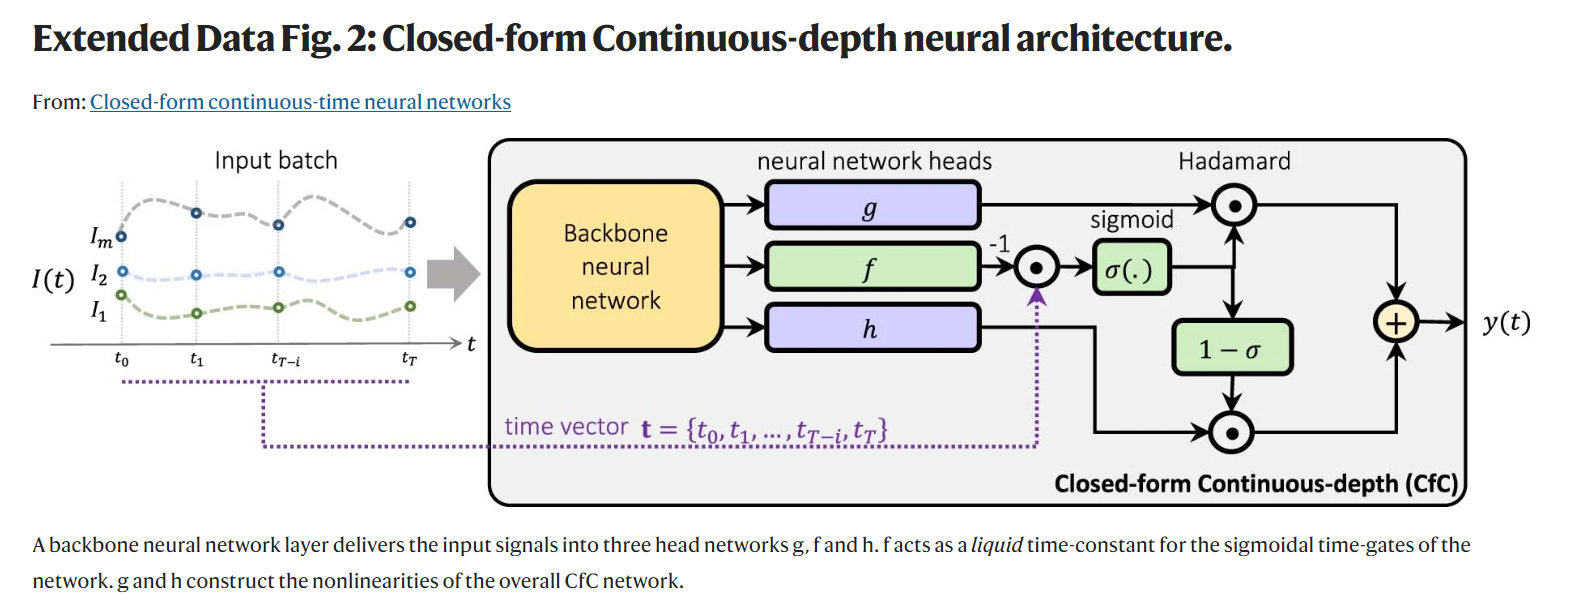

In [ ]:
class CFCImprovedCell(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=4, activation_type=nn.Tanh, num_backbone_neurons=4, num_backbone_layers=1, dropout=None):
        super(CFCImprovedCell, self).__init__()

        # Сохраняем параметры
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation_type = activation_type
        self.num_backbone_neurons = num_backbone_neurons

        # Доп слои для backbone, кроме первого обязательного
        extra_layers = [
            nn.Linear(num_backbone_neurons, num_backbone_neurons),
            self.activation_type(),
            nn.Dropout(dropout) if dropout is not None else nn.Identity()
        ] * (num_backbone_layers - 1)

        # Задаем backbone слои, все аналогичено CFCSolutionCell
        self.backbone = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, num_backbone_neurons),
            self.activation_type(),
            *extra_layers
        )

        # Задаем активанции и головы после backbone: f,g,h,w_tau_approx
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.head_f = nn.Linear(num_backbone_neurons, hidden_dim)
        self.head_g = nn.Linear(num_backbone_neurons, hidden_dim)
        self.head_h = nn.Linear(num_backbone_neurons, hidden_dim)
        self.w_tau_approx = nn.Linear(num_backbone_neurons, hidden_dim)

    def forward(self, inputs, hx, ts):
        batch_size = inputs.size(0)  # Размер батча
        ts = ts.view(batch_size, 1)  # Меня представление маркеров времени чтоб соответствовало
        x = torch.cat([inputs, hx], 1)  # Конкатенируем входы и hidden states

        x = self.backbone(x)  # Пропускаем через backbone
        
        # Считаем головы для значений функций h, g, f 
        head_h = self.tanh(self.head_h(x))
        head_g = self.tanh(self.head_g(x))
        head_f = self.head_f(x)

        # Считаем аппроксимацию w_tau
        w_tau_approx = self.w_tau_approx(x)
        
        # Считаем значение сигмы как в уравнении в статье
        # Внимание: здесь реализация отличается от референсной реализации авторов:
        # Вместо обычного добавления w_tau_approx, мы также умножаем на ts, как в оригинальной формуле.
        # Я попросил авторов прокомментировать, жду их ответа.
        sigma = self.sigmoid((w_tau_approx + head_f)* ts)
        
        # Подставляем в формулу уравнения (4) и считаем hidden state
        new_hidden = head_h * (1.0 - sigma) + sigma * head_g

        return new_hidden

## Реализация класса CFCRNN
Класс CFCRNN создает рекуррентную нейронную сеть, используя несколько экземпляров CFCSolutionCell\CFCImprovedCell. Он обрабатывает последовательности входных данных для получения последовательностей выходных данных.

Примечание. В этом руководстве предполагается, что CFCRNN будет вызываться одним выстрелом для всей последовательности, следовательно, инициализация состояния равна нулю при каждом прямом проходе.

In [ ]:
# Define the CFC RNN class
class CFCRNN(nn.Module):
    def __init__(self, cfc_cell, input_dim, hidden_dim, output_dim):
        super(CFCRNN, self).__init__()
        self.cell = cfc_cell  # Сохраняем CFC cell
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.out_proj = nn.Linear(hidden_dim, output_dim)  # Проекционный слой для выходов

    def forward(self, inputs, timespans):
        batch_size, seq_len, _ = inputs.size()  # получаем размер батча и длину последовательности
        
        states = torch.zeros(batch_size, self.hidden_dim)  # Инициализируем hidden state нулями
        outputs = []  # Список для хранения выходов на каждом этапе последовательности

        for t in range(seq_len):
            # Считаем выход на каждом шаге последовательности и сохраняем hidden state
            states = self.cell(inputs[:, t, :], states, timespans[:, t])
            outputs.append(self.out_proj(states))  # Проецируем hidden state в выходное значение и сохраняем

        result = torch.stack(outputs, dim=1)  # стэкаем выходные данные
        return result

## Генерация спиральных данных
Мы сгенерируем набор данных спиральных траекторий для обучения и оценки нашей модели. Функция generate_spiral_data создает синтетические точки данных, образующие спиральный узор.

In [ ]:
def generate_spiral_data(num_points, num_turns, noise=0.5):
    theta = np.linspace(0, num_turns * 2 * np.pi, num_points)
    z = np.linspace(0, 1, num_points)
    r = z  
    x = r * np.sin(theta) + noise * np.random.randn(*theta.shape) / num_points
    y = r * np.cos(theta) + noise * np.random.randn(*theta.shape) / num_points
    return np.stack([x, y], axis=1)

## Обучение модели
Далее мы устанавливаем гиперпараметры и готовим данные для обучения. Мы определяем цикл обучения для обучения модели с использованием сгенерированных спиральных данных.

In [ ]:
# Гиперпараметры
input_dim = 2
hidden_dim = 4
output_dim = 2

num_points = 300  # Количество точек в спирали
num_turns = 3  # Количество витков в спирали
learning_rate = 0.002  # Скорость обучения для оптимизатора
num_epochs = 2000  # Количество эпох для обучения
seq_len = 3  # Длина последовательности
batch_size = 32  # Размер батча
tau = 0.5  # tau временная константа

# Генерация данных спирали
data = generate_spiral_data(num_points, num_turns)
all_inputs = data[:-1, :]  # Все входные данные, кроме последней точки
all_targets = data[1:, :]  # Все целевые значения, кроме первой точки

# Подготовка входных и целевых последовательностей
trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

# Перемешивание и разделение данных на обучающие и валидационные наборы
random_train_indices = np.arange(len(train_inputs))
np.random.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

# Функция для создания батчей из списка данных
def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

# Создание входных и целевых батчей
train_input_batches = create_batches(train_inputs, batch_size)
train_target_batches = create_batches(train_targets, batch_size)

# Инициализация ячейки CFC Improved и модели RNN
# можно так же cell = CFCSolutionCell(input_dim, hidden_dim)
cell = CFCImprovedCell(input_dim, hidden_dim)
model = CFCRNN(cell, input_dim, hidden_dim, output_dim)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Цикл обучения
for epoch in range(num_epochs):
    model.train()  # Установить режим обучения модели
    total_loss = 0  # Инициализация общего значения потерь

    # Итерация по батчам
    for x, y_target in zip(train_input_batches, train_target_batches):
        optimizer.zero_grad()  # Обнулить градиенты
        x = torch.stack(x)  # Объединить батч последовательностей
        y_target = torch.stack(y_target)  # Объединить батч целевых значений
        timespans = torch.ones(x.shape[0], x.shape[1], 1) * tau  # Создать тензор временных промежутков
        outputs = model(x, timespans)  # Прямой проход через модель
        loss = criterion(outputs, y_target)  # Вычислить потери

        total_loss += loss.item()  # Накопить общее значение потерь
        loss.backward()  # Обратный проход
        optimizer.step()  # Шаг оптимизации

    # Выводить потери каждые 100 эпох и строить прогнозы
    if (epoch + 1) % 100 == 0:
        model.eval()  # Установить режим оценки модели
        with torch.no_grad():  # Отключить вычисление градиентов
            timespans = torch.ones(1, len(all_inputs), 1) * tau  # Создать тензор временных промежутков
            predictions = model(torch.FloatTensor(all_inputs).unsqueeze(0), timespans)  # Получить прогнозы
            np_predictions = predictions.squeeze(0).numpy()  # Преобразовать прогнозы в numpy массив
            val_loss = criterion(predictions, torch.FloatTensor(all_targets).unsqueeze(0))  # Вычислить валидационные потери
        
        # Выводить тренировочные и валидационные потери
        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.4f}, Total val loss: {val_loss:.4f}')

        # Построить истинный путь и предсказанный путь
        plt.plot(all_targets[:, 0], all_targets[:, 1], 'g-', label='True Path')
        plt.plot(np_predictions[:, 0], np_predictions[:, 1], 'r-', label='Predicted Path')
        plt.legend()
        plt.show()

# Заключение
В этом уроке мы реализовали классический LNN CfC, как описано в оригинальной статье. 

В архитектуре LNN доступны и другие улучшения. 
Такие как:
* [LTC-SE](https://arxiv.org/abs/2304.08691)
* [Liquid-S4](https://arxiv.org/abs/2209.12951)